In [2]:
import numpy as np 
import tensorflow as tf
import pandas as pd
from tqdm import tqdm
import os
from cv2 import imread, createCLAHE 
import cv2
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

image_path = os.path.join("D:/aminur/chest_lung_seg/108201_258315_bundle_archive/Lung Segmentation/CXR_png")
mask_path = os.path.join("D:/aminur/chest_lung_seg/108201_258315_bundle_archive/Lung Segmentation/","masks/")

In [3]:
# we have 704 masks but 800 images. Hence we are going to
# make a 1-1 correspondance from mask to images, not the usual other way.
images = os.listdir(image_path)
mask = os.listdir(mask_path)
mask = [fName.split(".png")[0] for fName in mask]
image_file_name = [fName.split("_mask")[0] for fName in mask]

In [4]:
check = [i for i in mask if "mask" in i]
print("Total mask that has modified name:",len(check))

Total mask that has modified name: 566


In [5]:
testing_files = set(os.listdir(image_path)) & set(os.listdir(mask_path))
training_files = check

def getData(X_shape, flag = "test"):
    im_array = []
    mask_array = []
    
    if flag == "test":
        for i in tqdm(testing_files): 
            im = cv2.resize(cv2.imread(os.path.join(image_path,i)),(X_shape,X_shape))[:,:,0]
            mask = cv2.resize(cv2.imread(os.path.join(mask_path,i)),(X_shape,X_shape))[:,:,0]
            
            im_array.append(im)
            mask_array.append(mask)
        
        return im_array,mask_array
    
    if flag == "train":
        for i in tqdm(training_files): 
            im = cv2.resize(cv2.imread(os.path.join(image_path,i.split("_mask")[0]+".png")),(X_shape,X_shape))[:,:,0]
            mask = cv2.resize(cv2.imread(os.path.join(mask_path,i+".png")),(X_shape,X_shape))[:,:,0]
            im_array.append(im)
            mask_array.append(mask)

        return im_array,mask_array

In [6]:

def plotMask(X,y):
    sample = []
    
    for i in range(6):
        left = X[i]
        right = y[i]
        combined = np.hstack((left,right))
        sample.append(combined)
        
        
    for i in range(0,6,3):

        plt.figure(figsize=(25,10))
        
        plt.subplot(2,3,1+i)
        plt.imshow(sample[i])
        
        plt.subplot(2,3,2+i)
        plt.imshow(sample[i+1])
        
        
        plt.subplot(2,3,3+i)
        plt.imshow(sample[i+2])
        
        plt.show()

In [7]:
# Load training and testing data
dim = 128
X_train,y_train = getData(dim,flag="train")
X_test, y_test = getData(dim)

100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [00:40<00:00,  3.45it/s]


training set


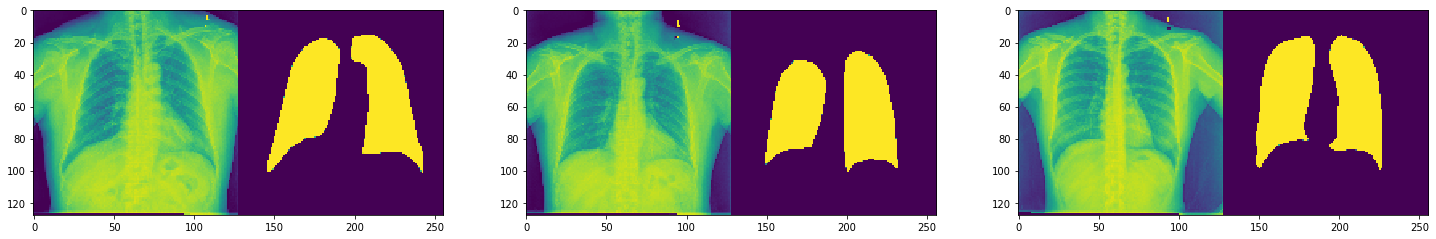

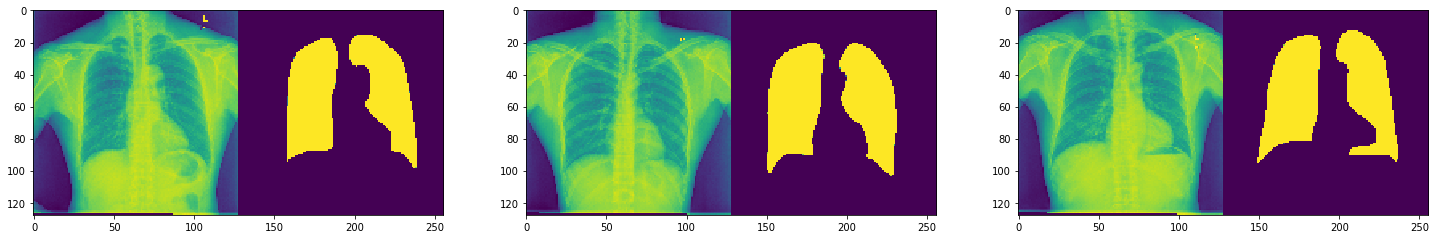

testing set


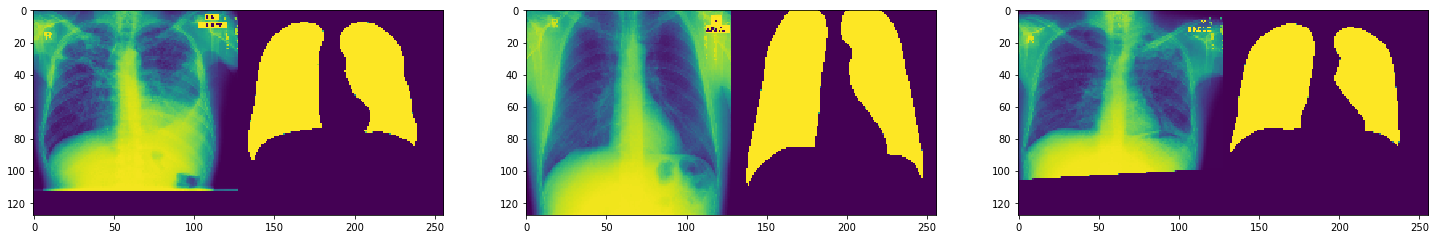

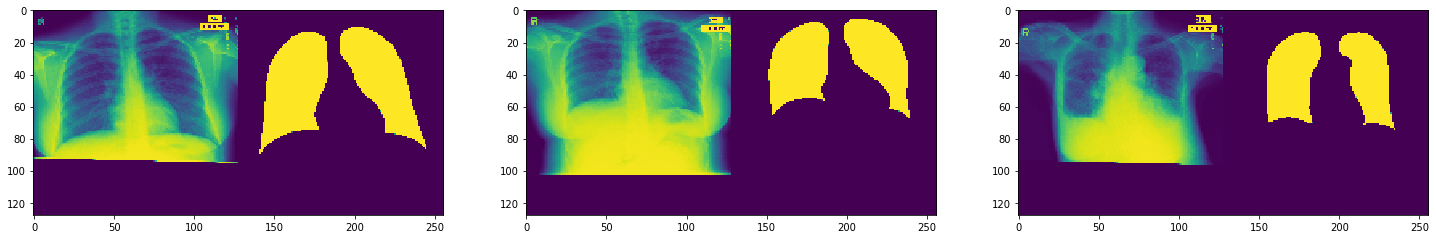

In [8]:
print("training set")
plotMask(X_train,y_train)
print("testing set")
plotMask(X_test,y_test)

In [9]:
X_train = np.array(X_train).reshape(len(X_train),dim,dim,1)
y_train = np.array(y_train).reshape(len(y_train),dim,dim,1)
X_test = np.array(X_test).reshape(len(X_test),dim,dim,1)
y_test = np.array(y_test).reshape(len(y_test),dim,dim,1)
assert X_train.shape == y_train.shape
assert X_test.shape == y_test.shape
images = np.concatenate((X_train,X_test),axis=0)
mask  = np.concatenate((y_train,y_test),axis=0)

In [24]:
from keras.layers import Conv2D,PReLU,Conv2DTranspose,add,concatenate,Input,Dropout,BatchNormalization,Activation
from keras.optimizers import Nadam
from keras.models import Model
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
#from keras import backend as keras

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler


def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)
  
    

def resBlock(conv,stage,keep_prob,stage_num=5):
    
    inputs=conv
    
    for _ in range(3 if stage>3 else stage):
        conv=PReLU()(BatchNormalization()(Conv2D(16*(2**(stage-1)), 5, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv)))
        #print('conv_down_stage_%d:' %stage,conv.get_shape().as_list())
    conv_add=PReLU()(add([inputs,conv]))
    #print('conv_add:',conv_add.get_shape().as_list())
    conv_drop=Dropout(keep_prob)(conv_add)
    
    if stage<stage_num:
        conv_downsample=PReLU()(BatchNormalization()(Conv2D(16*(2**stage), 2, strides=(2, 2),activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv_drop)))
        return conv_downsample,conv_add
    else:
        return conv_add,conv_add
        
def up_resBlock(forward_conv,input_conv,stage):
    
    conv=concatenate([forward_conv,input_conv],axis = -1)
    print('conv_concatenate:',conv.get_shape().as_list())
    for _ in range(3 if stage>3 else stage):
        conv=PReLU()(BatchNormalization()(Conv2D(16*(2**(stage-1)), 5, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv)))
        print('conv_up_stage_%d:' %stage,conv.get_shape().as_list())
    conv_add=PReLU()(add([input_conv,conv]))
    if stage>1:
        conv_upsample=PReLU()(BatchNormalization()(Conv2DTranspose(16*(2**(stage-2)),2,strides=(2, 2),padding='valid',activation = None,kernel_initializer = 'he_normal')(conv_add)))
        return conv_upsample
    else:
        return conv_add

def vnet(pretrained_weights = None,input_size = (128,128,1),num_class=1,is_training=True,stage_num=5,thresh=0.5):
    keep_prob = 1.0 if is_training else 1.0
    features=[]
    input_model = Input(input_size)
    x=PReLU()(BatchNormalization()(Conv2D(16, 5, activation = None, padding = 'same', kernel_initializer = 'he_normal')(input_model)))
    
    for s in range(1,stage_num+1):
        x,feature=resBlock(x,s,keep_prob,stage_num)
        features.append(feature)
        
    conv_up=PReLU()(BatchNormalization()(Conv2DTranspose(16*(2**(s-2)),2,strides=(2, 2),padding='valid',activation = None,kernel_initializer = 'he_normal')(x)))
    
    for d in range(stage_num-1,0,-1):
        conv_up=up_resBlock(features[d-1],conv_up,d)
    if num_class>1:
        conv_out=Conv2D(num_class, 1, activation = 'softmax', padding = 'same', kernel_initializer = 'he_normal')(conv_up)
    else:
        conv_out=Conv2D(num_class, 1, activation = 'sigmoid', padding = 'same', kernel_initializer = 'he_normal')(conv_up)
    
    
    
    
    model=Model(inputs=input_model,outputs=conv_out)
    print(model.output_shape)
    
    return model

In [25]:
model = vnet(input_size=(128,128,1))
#lr=1e-5
model.compile(optimizer=Adam(lr=.00001), loss=dice_coef_loss,
                  metrics=[dice_coef, 'binary_accuracy'])
model.summary()

conv_concatenate: [None, 16, 16, 256]
conv_up_stage_4: [None, 16, 16, 128]
conv_up_stage_4: [None, 16, 16, 128]
conv_up_stage_4: [None, 16, 16, 128]
conv_concatenate: [None, 32, 32, 128]
conv_up_stage_3: [None, 32, 32, 64]
conv_up_stage_3: [None, 32, 32, 64]
conv_up_stage_3: [None, 32, 32, 64]
conv_concatenate: [None, 64, 64, 64]
conv_up_stage_2: [None, 64, 64, 32]
conv_up_stage_2: [None, 64, 64, 32]
conv_concatenate: [None, 128, 128, 32]
conv_up_stage_1: [None, 128, 128, 16]
(None, 128, 128, 1)
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 128, 128, 16) 416         input_2[0][0]        

Total params: 12,695,457
Trainable params: 12,689,825
Non-trainable params: 5,632
__________________________________________________________________________________________________


In [26]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('cxr_reg')

checkpoint = ModelCheckpoint('model_vnet_Xray.h5', monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                   patience=5, 
                                   verbose=1, mode='min', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=15) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint,early, reduceLROnPlat]

D:\Anaconda3\envs\deep\lib\site-packages\keras\callbacks\callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [27]:
from IPython.display import clear_output
from keras.optimizers import Adam 
from sklearn.model_selection import train_test_split
#lr=2e-4
model.compile(optimizer=Adam(lr=2e-4), 
              loss=[dice_coef_loss], 
           metrics = [dice_coef, 'binary_accuracy'])

train_vol, validation_vol, train_seg, validation_seg = train_test_split((images-127.0)/127.0, 
                                                            (mask>127).astype(np.float32), 
                                                            test_size = 0.1,random_state = 2018)

#train_vol, test_vol, train_seg, test_seg = train_test_split(train_vol,train_seg, 
 #                                                           test_size = 0.1, 
  #                                                          random_state = 2018)

loss_history = model.fit(x = train_vol,
                       y = train_seg,
                         batch_size = 8,
                  epochs = 200,
                  validation_data =(validation_vol,validation_seg) ,
                  callbacks=callbacks_list)


#clear_output()

Train on 633 samples, validate on 71 samples
Epoch 1/200
633/633 [==============================] - 18s 29ms/step - loss: -0.6989 - dice_coef: 0.7000 - binary_accuracy: 0.8685 - val_loss: -0.7501 - val_dice_coef: 0.7499 - val_binary_accuracy: 0.9210

Epoch 00001: val_loss improved from inf to -0.75010, saving model to model_vnet_Xray.h5
Epoch 2/200
633/633 [==============================] - 11s 18ms/step - loss: -0.8567 - dice_coef: 0.8571 - binary_accuracy: 0.9680 - val_loss: -0.8239 - val_dice_coef: 0.8238 - val_binary_accuracy: 0.9679

Epoch 00002: val_loss improved from -0.75010 to -0.82388, saving model to model_vnet_Xray.h5
Epoch 3/200
633/633 [==============================] - 11s 18ms/step - loss: -0.8922 - dice_coef: 0.8924 - binary_accuracy: 0.9736 - val_loss: -0.8555 - val_dice_coef: 0.8555 - val_binary_accuracy: 0.9597

Epoch 00003: val_loss improved from -0.82388 to -0.85549, saving model to model_vnet_Xray.h5
Epoch 4/200
633/633 [==============================] - 11s 18ms

633/633 [==============================] - 11s 18ms/step - loss: -0.9872 - dice_coef: 0.9872 - binary_accuracy: 0.9947 - val_loss: -0.9577 - val_dice_coef: 0.9577 - val_binary_accuracy: 0.9793

Epoch 00029: val_loss did not improve from -0.95813
Epoch 30/200
633/633 [==============================] - 11s 18ms/step - loss: -0.9879 - dice_coef: 0.9878 - binary_accuracy: 0.9949 - val_loss: -0.9584 - val_dice_coef: 0.9585 - val_binary_accuracy: 0.9796

Epoch 00030: val_loss improved from -0.95813 to -0.95839, saving model to model_vnet_Xray.h5
Epoch 31/200
633/633 [==============================] - 11s 18ms/step - loss: -0.9882 - dice_coef: 0.9879 - binary_accuracy: 0.9951 - val_loss: -0.9581 - val_dice_coef: 0.9582 - val_binary_accuracy: 0.9794

Epoch 00031: val_loss did not improve from -0.95839
Epoch 32/200
633/633 [==============================] - 11s 18ms/step - loss: -0.9865 - dice_coef: 0.9865 - binary_accuracy: 0.9942 - val_loss: -0.9567 - val_dice_coef: 0.9568 - val_binary_accura


Epoch 00058: val_loss did not improve from -0.96035
Epoch 59/200
633/633 [==============================] - 11s 18ms/step - loss: -0.9972 - dice_coef: 0.9971 - binary_accuracy: 0.9991 - val_loss: -0.9601 - val_dice_coef: 0.9602 - val_binary_accuracy: 0.9800

Epoch 00059: val_loss did not improve from -0.96035

Epoch 00059: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
Epoch 60/200
633/633 [==============================] - 11s 18ms/step - loss: -0.9972 - dice_coef: 0.9971 - binary_accuracy: 0.9991 - val_loss: -0.9601 - val_dice_coef: 0.9601 - val_binary_accuracy: 0.9799

Epoch 00060: val_loss did not improve from -0.96035
Epoch 61/200
633/633 [==============================] - 11s 18ms/step - loss: -0.9973 - dice_coef: 0.9973 - binary_accuracy: 0.9992 - val_loss: -0.9601 - val_dice_coef: 0.9601 - val_binary_accuracy: 0.9799

Epoch 00061: val_loss did not improve from -0.96035
Epoch 62/200
633/633 [==============================] - 12s 18ms/step - loss: -0.9974 - d

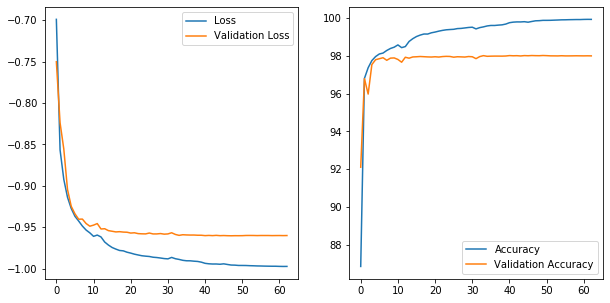

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.plot(loss_history.history['loss'], '-', label = 'Loss')
ax1.plot(loss_history.history['val_loss'], '-', label = 'Validation Loss')
ax1.legend()

ax2.plot(100*np.array(loss_history.history['binary_accuracy']), '-', 
         label = 'Accuracy')
ax2.plot(100*np.array(loss_history.history['val_binary_accuracy']), '-',
         label = 'Validation Accuracy')
ax2.legend()

In [29]:
'''
pred_candidates = np.random.randint(1,validation_vol.shape[0],10)
preds = model.predict(validation_vol,batch_size=1,verbose=1)

plt.figure(figsize=(20,10))

for i in range(0,9,3):
    plt.subplot(3,3,i+1)
    
    plt.imshow(np.squeeze(validation_vol[pred_candidates[i]]))
    plt.xlabel("Base Image")
    
    
    plt.subplot(3,3,i+2)
    plt.imshow(np.squeeze(validation_seg[pred_candidates[i]]))
    plt.xlabel("Mask")
    
    plt.subplot(3,3,i+3)
    plt.imshow(np.squeeze(preds[pred_candidates[i]]))
    plt.xlabel("Pridiction")'''

'\npred_candidates = np.random.randint(1,validation_vol.shape[0],10)\npreds = model.predict(validation_vol,batch_size=1,verbose=1)\n\nplt.figure(figsize=(20,10))\n\nfor i in range(0,9,3):\n    plt.subplot(3,3,i+1)\n    \n    plt.imshow(np.squeeze(validation_vol[pred_candidates[i]]))\n    plt.xlabel("Base Image")\n    \n    \n    plt.subplot(3,3,i+2)\n    plt.imshow(np.squeeze(validation_seg[pred_candidates[i]]))\n    plt.xlabel("Mask")\n    \n    plt.subplot(3,3,i+3)\n    plt.imshow(np.squeeze(preds[pred_candidates[i]]))\n    plt.xlabel("Pridiction")'

In [30]:
model.load_weights('model_vnet_Xray.h5')
print (validation_vol.shape,type(validation_vol))

(71, 128, 128, 1) <class 'numpy.ndarray'>


64/64 [==============================] - 2s 29ms/step


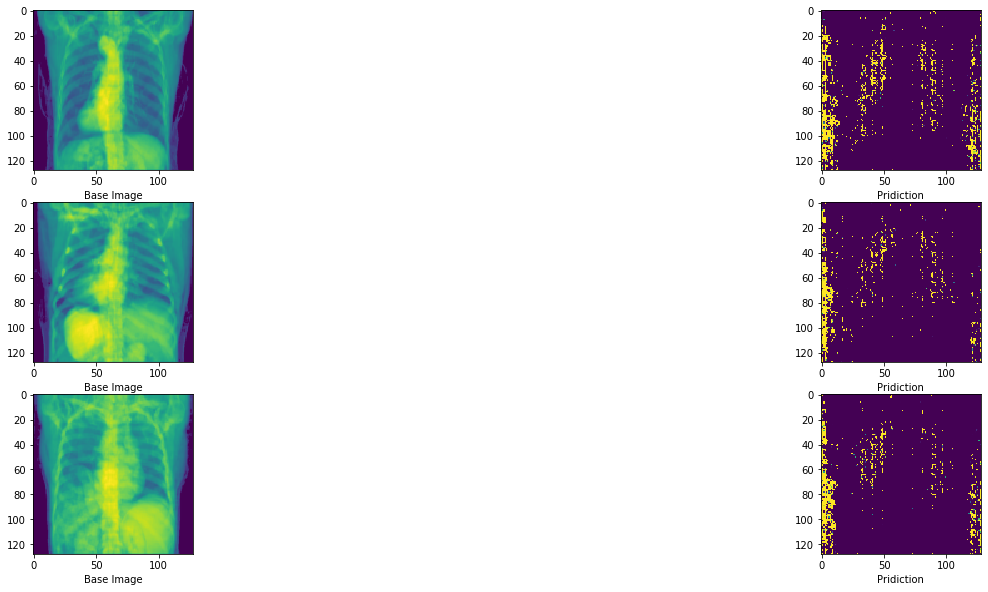

In [31]:
X=np.load('D:/aminur/data/lung.npy')
pred_candidates = np.random.randint(1,X.shape[0],10)
preds = model.predict(X,batch_size=1,verbose=1)

plt.figure(figsize=(20,10))

for i in range(0,9,3):
    plt.subplot(3,3,i+1)
    
    plt.imshow(np.squeeze(X[pred_candidates[i]]))
    plt.xlabel("Base Image")
    
    
    plt.subplot(3,3,i+3)
    plt.imshow(np.squeeze(preds[pred_candidates[i]]))
    plt.xlabel("Pridiction")